# Delta Function

This notebook presents an agent-based model that simulates the propagation of a disease through a network.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [3]:
# Model design
import agentpy as ap
import networkx as nx 
import random 
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

## About the model

The agents of this model are people, which can be in one of the following three conditions: susceptible to the disease (S), infected (I), or recovered (R). The agents are connected to each other through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

## Defining the model

We define a new agent type :class:`Person` by creating a subclass of :class:`Agent`.
This agent has two methods: :func:`setup` will be called automatically at the agent's creation,
and :func:`being_sick` will be called by the :func:`Model.step` function.
Three tools are used within this class:

- :attr:`Agent.p` returns the parameters of the model
- :func:`Agent.neighbors` returns a list of the agents' peers in the network
- :func:`random.random` returns a uniform random draw between 0 and 1

wealth by race https://www.federalreserve.gov/econres/notes/feds-notes/disparities-in-wealth-by-race-and-ethnicity-in-the-2019-survey-of-consumer-finances-20200928.html

rank for the US:
https://www.federalreserve.gov/econres/notes/feds-notes/wealth-inequality-and-the-racial-wealth-gap-accessible-20211022.htm#fig3


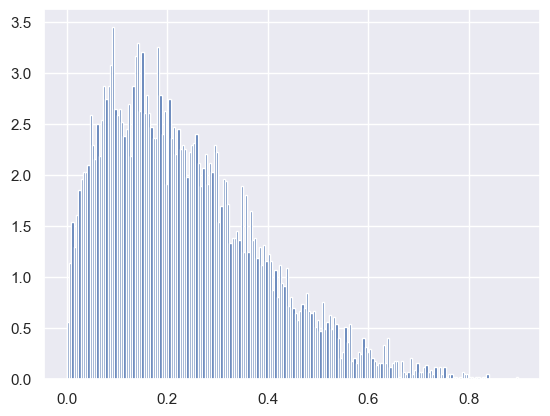

In [38]:
import matplotlib.pyplot as plt

values = plt.hist(np.random.beta(1.5, 5, 10000),

                  bins=200, density=True)

plt.show()

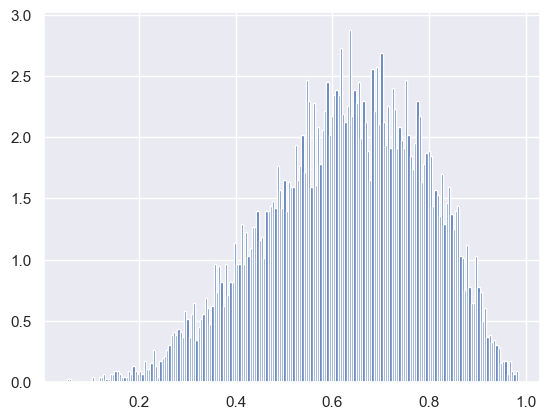

In [39]:
import matplotlib.pyplot as plt

values = plt.hist(np.random.beta(5, 3, 10000),

                  bins=200, density=True)

plt.show()

In [6]:
class Person(ap.Agent):
    
    def setup(self):  
        """ Initialize a new variable at agent creation. """
        # self.condition = 0  # Susceptible = 0, Infected = 1, Recovered = 2
        a = 5 # shape
        rng = np.random.default_rng()
        
        
        # race
        self.race =  rng.binomial(1,0.2)#binary not white0.2 /  white for the moment 0.8
        
        if self.race == 0:
            self.wealth = rng.beta(1.5, 5,1)[0]
        else:
            self.wealth = rng.beta(5, 3,1)[0]
            

        # fraud
        self.fraud = rng.binomial(1,0.5,1)[0]
        self.fraud_pred = -1
        self.convicted = 0

        
    def fraud_algo(self):
        """ DM mechanism can also be ML"""
        rng = np.random.default_rng()
        # self.fraud_pred = rng.binomial(1, 0.5)
        if self.fraud == 1:
            fraud_cor = rng.binomial(1,self.p.acc)
        else:
            fraud_cor = rng.binomial(1,1-self.p.acc)
            
        self.fraud_pred = rng.binomial(1, fraud_cor*(0.8-self.p.wealth_appeal_corr))
        

    def appeal(self):
        """Possibility to Appeal to Fraud Algo Decision"""
        rng = np.random.default_rng()
#         print('bye')
        if self.fraud_pred == 1 and self.wealth > self.p.appeal_wealth:
            self.fraud_algo()
            # self.fraud_pred = rng.binomial(1, 0.4)
            
    def convict(self):
        """ Conviction and Consequences"""
        rng = np.random.default_rng()
        if self.fraud_pred == 1:
            if rng.binomial(1,0.8) == 1:
                # pay fine, get on record, 
                self.wealth = self.wealth - np.max([0.01,(self.wealth*0.05)])
                self.convicted =+ 1
                self.fraud = rng.binomial(1,0.5,1)[0]
                self.fraud_pred = 0
    
    def wealth_grow(self):
        self.wealth = min(1,self.wealth+pow(self.wealth,2)*0.01)
            
            
        


#     def step(self):
#         # The agent's step will go here.
#         # For demonstration purposes we will print the agent's unique_id
#         self.appeal()
#         print("Hi, I am agent " + str(self.unique_id) + ".")
#         # print("my wealth, job, fraud, fraud_pred is:" + str(self.wealth)+ str(self.job) + str(self.fraud)+ str(self.fraud_pred))

Next, we define our model :class:`VirusModel` by creating a subclass of :class:`Model`.
The four methods of this class will be called automatically at different steps of the simulation,
as described in :ref:`overview_simulation`.

In [7]:
class VirusModel_baseline(ap.Model):
    
    def setup(self): #before
        """ Initialize the agents and network of the model. """
        
        # Create agents and network
        self.agents = ap.AgentList(self, self.p.agents, Person)
    
        self.w_wealth_t0 = sum((self.agents.select(self.agents.race == 1)).wealth) / len((self.agents.select(self.agents.race == 1)))
        self.nw_wealth_t0 = sum((self.agents.select(self.agents.race == 0)).wealth) / len((self.agents.select(self.agents.race == 0)))
    

    def step(self): # during each step
        """ Define the models' events per simulation step. """
        self.agents.fraud_algo()
#         self.agents.appeal()
        self.agents.convict()
        self.agents.wealth_grow()
        


    def update(self):  # after each step
        """ Record variables after setup and each step. """
        self.agents.record('wealth')
        self.agents.record('fraud_pred')
        self.agents.record('fraud')
        self.agents.record('race')
        
        
    
    def end(self):     
        """ Record evaluation measures at the end of the simulation. """
#         self.report('wealth', self.agents.wealth)
#         self.report('race', self.agents.race)
#         self.report('my_measure', 1)
        
        # record race wealth ratio 
        
        w_wealth_tn = sum((self.agents.select(self.agents.race == 1)).wealth) / len((self.agents.select(self.agents.race == 1)))
        nw_wealth_tn = sum((self.agents.select(self.agents.race == 0)).wealth) / len((self.agents.select(self.agents.race == 0)))
        
        w_wr_ratio = w_wealth_tn/self.w_wealth_t0
        nw_wr_ratio = nw_wealth_tn/self.nw_wealth_t0
        
        self.report('w_wr_ratio', w_wr_ratio)
        self.report('nw_wr_ratio', nw_wr_ratio)
            
        
        
#         # Record final evaluation measures
#         self.report('Total share infected', self.I + self.R) 
#         self.report('Peak share infected', max(self.log['I']))

In [8]:
class VirusModel(ap.Model):
    
    def setup(self): #before
        """ Initialize the agents and network of the model. """
        
        # Create agents and network
        self.agents = ap.AgentList(self, self.p.agents, Person)
    
        self.w_wealth_t0 = sum((self.agents.select(self.agents.race == 1)).wealth) / len((self.agents.select(self.agents.race == 1)))
        self.nw_wealth_t0 = sum((self.agents.select(self.agents.race == 0)).wealth) / len((self.agents.select(self.agents.race == 0)))
    

    def step(self): # during each step
        """ Define the models' events per simulation step. """
        self.agents.fraud_algo()
        self.agents.appeal()
        self.agents.convict()
        self.agents.wealth_grow()
        


    def update(self):  # after each step
        """ Record variables after setup and each step. """
        self.agents.record('wealth')
        self.agents.record('fraud_pred')
        self.agents.record('fraud')
        self.agents.record('race')
        
        
    
    def end(self):     
        """ Record evaluation measures at the end of the simulation. """
#         self.report('wealth', self.agents.wealth)
#         self.report('race', self.agents.race)
#         self.report('my_measure', 1)
        
        # record race wealth ratio 
        
        w_wealth_tn = sum((self.agents.select(self.agents.race == 1)).wealth) / len((self.agents.select(self.agents.race == 1)))
        nw_wealth_tn = sum((self.agents.select(self.agents.race == 0)).wealth) / len((self.agents.select(self.agents.race == 0)))
        
        w_wr_ratio = w_wealth_tn/self.w_wealth_t0
        nw_wr_ratio = nw_wealth_tn/self.nw_wealth_t0
        
        self.report('w_wr_ratio', w_wr_ratio)
        self.report('nw_wr_ratio', nw_wr_ratio)
            
        
        
#         # Record final evaluation measures
#         self.report('Total share infected', self.I + self.R) 
#         self.report('Peak share infected', max(self.log['I']))

## Vizualisation

In [9]:
def viz(data, x, y, hue):
    fig, ax = plt.subplots()

    sns.lineplot(ax = ax,
                 data = data,
                 x = x,
                 y = y,
                 hue = hue,
                 marker = 'o')

    plt.show()

## Running a simulation

To run our model, we define a dictionary with our parameters. 
We then create a new instance of our model, passing the parameters as an argument, 
and use the method :func:`Model.run` to perform the simulation and return it's output. 

Completed: 100 steps
Run time: 0:00:03.421262
Simulation finished


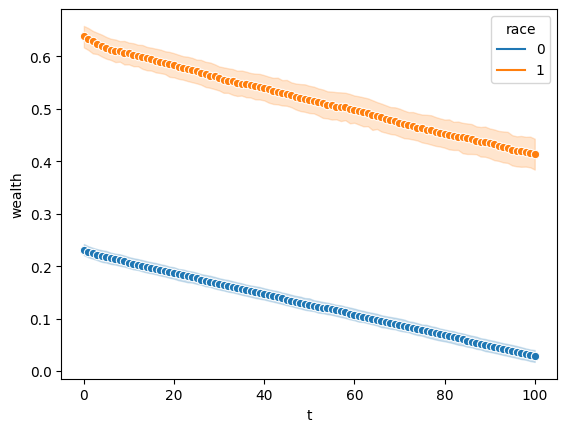

In [10]:
parameters = {
    'my_parameter':42,
    'agents':1000,
    'steps':100,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.8, # accuracy of fraud prdediction
    'appeal_wealth': 0.2 # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    
}

model_baseline = VirusModel_baseline(parameters)
results_baseline = model_baseline.run() 

df_baseline = results_baseline['variables']['Person']

viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'].astype(float), df_baseline['race'])

Completed: 100 steps
Run time: 0:00:04.516811
Simulation finished


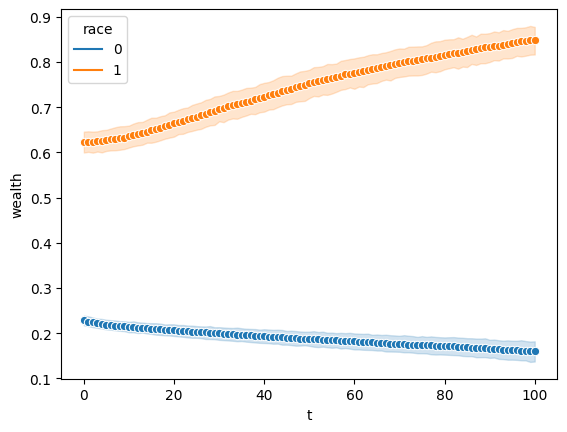

In [11]:
parameters = {
    'my_parameter':42,
    'agents':1000,
    'steps':100,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.8, # accuracy of fraud prdediction
    'appeal_wealth': 0.2 # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    
}

model = VirusModel(parameters)
results = model.run() 

df = results['variables']['Person']

viz(df, df.index.get_level_values('t'), df['wealth'].astype(float), df['race'])

In [12]:
# create baseline value
df_b1 = df_baseline.iloc[(df_baseline['race'] == 1).values] 
baseline1 = df_b1.groupby(level='t').mean()
# df_b
df_b0 = df_baseline.iloc[(df_baseline['race'] == 0).values] 
baseline0 = df_b0.groupby(level='t').mean()

In [13]:
df_x1 = df.iloc[(df['race'] == 1).values] 
df_wb1 = df_x1['wealth'] - baseline1['wealth']
df_x1['wealth'] = df_wb1




df_x0 = df.iloc[(df['race'] == 0).values] 
df_wb0 = df_x0['wealth'] - baseline0['wealth']
df_x0['wealth'] = df_wb0

df_xb = pd.concat([df_x0, df_x1])


/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_75881/2096043862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x1['wealth'] = df_wb1
/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_75881/2096043862.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x0['wealth'] = df_wb0


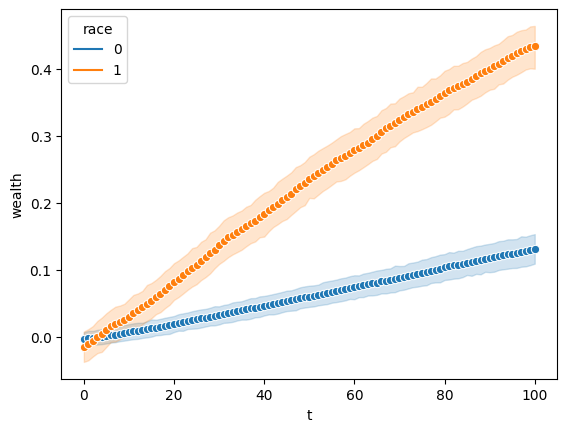

In [14]:
viz(df_xb, df_xb.index.get_level_values('t'), df_xb['wealth'].astype(float), df_xb['race'])

## Delta Function 

In [15]:
# run baseline and normal model and save results
model_baseline = VirusModel_baseline(parameters)
results_baseline = model_baseline.run() 

df_baseline = results_baseline['variables']['Person']

model = VirusModel(parameters)
results = model.run() 

df = results['variables']['Person']

Completed: 100 steps
Run time: 0:00:03.207256
Simulation finished
Completed: 100 steps
Run time: 0:00:04.557032
Simulation finished


In [16]:
# create baseline value
def delta_function(disc_axis, df, df_baseline):
    df_b1 = df_baseline.iloc[(df_baseline[disc_axis] == 1).values] 
    df_wb1 = df.iloc[(df[disc_axis] == 1).values] ['wealth'] - df_b1.groupby(level='t').mean()['wealth']
    df_x1['wealth'] = df_wb1
    
    df_b0 = df_baseline.iloc[(df_baseline[disc_axis] == 0).values] 
    df_wb0 = df.iloc[(df[disc_axis] == 0).values] ['wealth'] - df_b0.groupby(level='t').mean()['wealth']
    df_x0['wealth'] = df_wb0

    df_xb = pd.concat([df_x0, df_x1])
    
    return df_xb

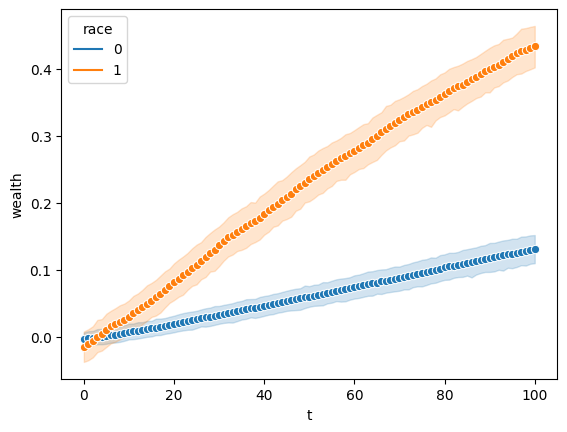

In [17]:
delta_function('race',df, df_baseline)
viz(df_xb, df_xb.index.get_level_values('t'), df_xb['wealth'].astype(float), df_xb['race'])

Do I want this or do I want just one line that indicates if r0 or r1 profits more?

## Sensitivity Analysis



1. First-order indices: measures the contribution to the output variance by a single model input alone.
2. Second-order indices: measures the contribution to the output variance caused by the interaction of two model inputs.
3. Total-order index: measures the contribution to the output variance caused by a model input, including both its first-order effects (the input varying alone) and all higher-order interactions.


### SALib

creates/samples model input and analyzes its out put with respect to its sensitivity.
Is independent from the computational model -> samples need to be looped over... 
=> seemes like last resort to me

### EMA Workbench
Powerful package with many different sesnitivity analysis.
Seems like maybe an overkill for now: https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/general-introduction.html


### Parameter sample module

used to sample multiple combinations from different parameter combinations \\
-> also possible to create interactive simulation (seems like a nice goal): https://agentpy.readthedocs.io/en/latest/guide_interactive.html [cant make the viz work]

seems like it covers everything

In [24]:
vm = VirusModel.as_function()
help(vm)



Help on function agentpy_model_as_function in module agentpy.model:

agentpy_model_as_function(**kwargs)
    Performs a simulation of the model 'VirusModel'.
    
    Arguments:
        **kwargs: Keyword arguments with parameter values.
    
    Returns:
        dict: Reporters of the model.



In [25]:
# parameters = {
#     'my_parameter':42,
#     'agents':1000,
#     'steps':100,
#     'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
#     'acc': 0.8, # accuracy of fraud prdediction
#     'appeal_wealth': 0.2 # minimal wealth needed for appeal (could also become a param for distr. eventually)
#     #'wealth_impact'
    
# }



# model = VirusModel(parameters)
# results = model.run() 

# df = results['variables']['Person']

# viz(df, df.index.get_level_values('t'), df['wealth'].astype(float), df['race'])

parameters = {
    'my_parameter':42,
    'agents':ap.IntRange(50, 150),
    'steps':10,
    'wealth_appeal_corr': ap.Range(-0.2, 0.2), # >0 more wealth higher appeal chance
    'acc': ap.Range(0.5, 0.8), # accuracy of fraud prdediction
    'appeal_wealth': 0.2 # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
} 

sample = ap.Sample(
    parameters, 
    n=128, 
    method='saltelli', 
    calc_second_order=True
)

In [26]:
exp = ap.Experiment(VirusModel, sample, iterations=2, record = True)
results = exp.run()

Scheduled runs: 2048
Completed: 2048, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:01:45.281055


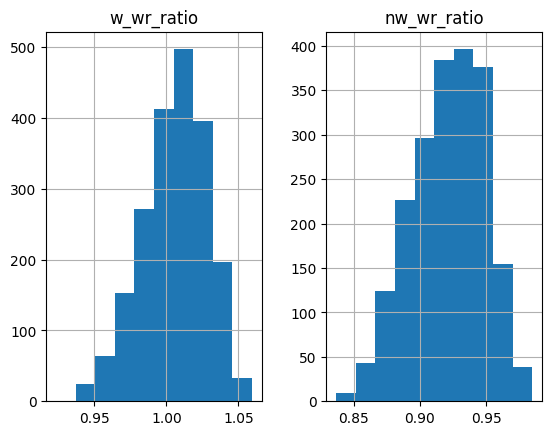

In [27]:
results.reporters.hist();

## Analyzing results

The simulation returns a :class:`DataDict` of recorded data with dataframes:

In [19]:
a =results['reporters']
a

,seed,w_wr_ratio,nw_wr_ratio
0,188128985266831577629065356606189446075,1.321873,0.689846


In [20]:
# a["wealth"].index

In [21]:
df = results['variables']['Person']
df

wealth  fraud_pred  fraud  race
obj_id t                                     
1      0    0.773374          -1      1     0
       1    0.779355           0      1     0
       2    0.745869           0      1     0
       3    0.751433           0      1     0
       4    0.757079           0      1     0
...              ...         ...    ...   ...
1000   96  -0.085795           0      0     0
       97  -0.085721           0      0     0
       98  -0.095630           0      1     0
       99  -0.105518           0      0     0
       100 -0.105407           0      0     0

[101000 rows x 4 columns]

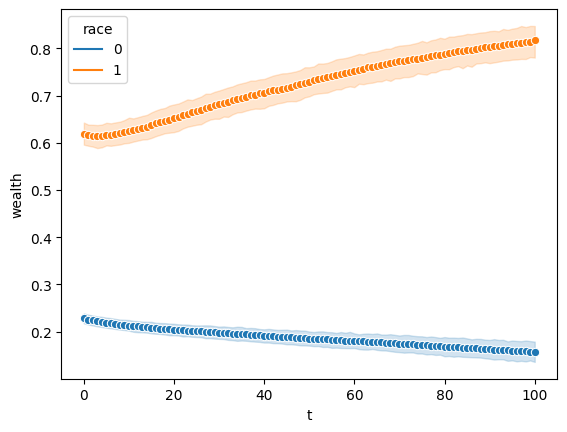

In [22]:
df = results['variables']['Person']
fig, ax = plt.subplots()

sns.lineplot(ax = ax,
             data = df,
             x = df.index.get_level_values('t'),
             y = df['wealth'].astype(float),
             hue = df['race'],
             marker = 'o')

plt.show()

To visualize the evolution of our variables over time, we create a plot function.

AttributeError: VirusModel

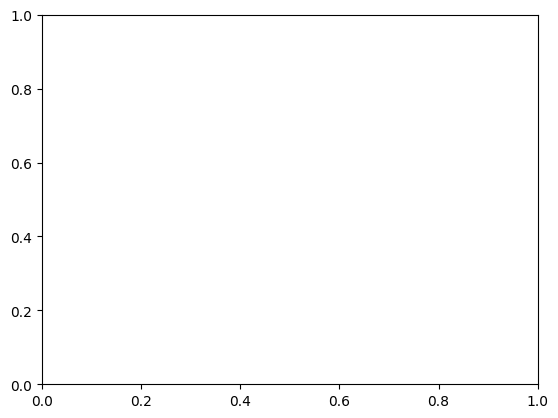

In [23]:
def virus_stackplot(data, ax):
    """ Stackplot of people's condition over time. """
    x = data.index.get_level_values('t')
    y = [data[var] for var in ['I', 'S', 'R']]
    
    sns.set()
    ax.stackplot(x, y, labels=['Infected', 'Susceptible', 'Recovered'],
                 colors = ['r', 'b', 'g'])    
    
    ax.legend()
    ax.set_xlim(0, max(1, len(x)-1))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Percentage of population")

fig, ax = plt.subplots()
virus_stackplot(results.variables.VirusModel, ax)

## Creating an animation

We can also animate the model's dynamics as follows.
The function :func:`animation_plot` takes a model instance 
and displays the previous stackplot together with a network graph. 
The function :func:`animate` will call this plot
function for every time-step and return an :class:`matplotlib.animation.Animation`.

In [ ]:
def animation_plot(m, axs):
    ax1, ax2 = axs
    ax1.set_title("Virus spread")
    ax2.set_title(f"Share infected: {m.I}")
    
    # Plot stackplot on first axis
    virus_stackplot(m.output.variables.VirusModel, ax1)
    
    # Plot network on second axis
    color_dict = {0:'b', 1:'r', 2:'g'}
    colors = [color_dict[c] for c in m.agents.condition]
    nx.draw_circular(m.network.graph, node_color=colors, 
                     node_size=50, ax=ax2)

fig, axs = plt.subplots(1, 2, figsize=(8, 4)) # Prepare figure 
parameters['population'] = 50 # Lower population for better visibility 
animation = ap.animate(VirusModel(parameters), fig, axs, animation_plot)

Using Jupyter, we can display this animation directly in our notebook.

In [ ]:
IPython.display.HTML(animation.to_jshtml()) 

## Multi-run experiment

To explore the effect of different parameter values, 
we use the classes :class:`Sample`, :class:`Range`, and :class:`IntRange`
to create a sample of different parameter combinations.

What I want is trying a bunch of 

In [ ]:
# parameters = {
#     'population': ap.IntRange(100, 1000),
#     'infection_chance': ap.Range(0.1, 1.),
#     'recovery_chance': ap.Range(0.1, 1.),
#     'initial_infection_share': 0.1,
#     'number_of_neighbors': 2,
#     'network_randomness': ap.Range(0., 1.)
# }
# parameters = {  
#     'population': 1000,
#     'infection_chance': 0.3,
#     'recovery_chance': 0.1,
#     'initial_infection_share': 0.1,
#     'number_of_neighbors': 2,
#     'network_randomness': 0.5   
# }

parameters = {
    'my_parameter':42,
    'agents':ap.IntRange(50, 150),
    'steps':10,
    'wealth_appeal_corr': ap.Range(-0.2, 0.2), # >0 more wealth higher appeal chance
    'acc': ap.Range(0.5, 0.8), # accuracy of fraud prdediction
    'appeal_wealth': 0.2 # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
} 

sample = ap.Sample(
    parameters, 
    n=128, 
    method='saltelli', 
    calc_second_order=True
)

We then create an :class:`Experiment` that takes a model and sample as input.
:func:`Experiment.run` runs our model repeatedly over the whole sample 
with ten random iterations per parameter combination.

In [ ]:
exp = ap.Experiment(VirusModel, sample, iterations=2, record = True)
results = exp.run()

Optionally, we can save and load our results as follows:

In [ ]:
results.save()

In [ ]:
results = ap.DataDict.load('VirusModel')

In [ ]:
results['reporters']

The measures in our :class:`DataDict` now hold one row for each simulation run.

In [ ]:
a =results['parameters']['sample']
a

In [ ]:
results['reporters']

We can use standard functions of the pandas library like 
:func:`pandas.DataFrame.hist` to look at summary statistics.

In [ ]:
results.reporters.hist();

## Sensitivity analysis

The function :func:`DataDict.calc_sobol` calculates `Sobol sensitivity
indices <https://salib.readthedocs.io/en/latest/api.html#sobol-sensitivity-analysis>`_ 
for the passed results and parameter ranges, using the 
`SAlib <https://salib.readthedocs.io/en/latest/basics.html>`_ package. 

In [28]:
results.calc_sobol()

/Users/uni/miniconda3/envs/ma/lib/python3.10/site-packages/agentpy/datadict.py:148: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  reporters_df = self.reporters.groupby('sample_id').mean()


DataDict {
'info': Dictionary with 12 keys
'parameters': 
    'constants': Dictionary with 3 keys
    'sample': DataFrame with 3 variables and 1024 rows
    'log': Dictionary with 5 keys
'variables': 
    'Person': DataFrame with 4 variables and 2252800 rows
'reporters': DataFrame with 3 variables and 2048 rows
'sensitivity': 
    'sobol': DataFrame with 5 variables and 6 rows
    'sobol_conf': DataFrame with 5 variables and 6 rows
}

In [29]:
results['reporters']

seed  w_wr_ratio  \
sample_id iteration                                                        
0         0            3984476341471602837984706486328898104    0.962079   
          1           14744180707140152026007418986953646190    1.012573   
1         0          254776665690844119000202478713809410705    0.995698   
          1          268201303746947523873435933022845429499    1.007090   
2         0           24521302076503583308065949653592960893    1.038494   
...                                                      ...         ...   
1021      1          187068669829644874645417583744432428303    1.042855   
1022      0          336995660948119805289474155310698517445    1.013618   
          1          285097310284510460252330035977851620971    1.015539   
1023      0           91231769281856813262764696479590566989    1.019763   
          1          297906932854648674742000136215634058514    1.021633   

                     nw_wr_ratio  
sample_id iteration               
0         0             0.884558  
          1             0.929365  
1         0             0.882351  
          1             0.910382  
2         0             0.951704  
...                          ...  
1021      1             0.973104  
1022      0             0.937995  
          1             0.939615  
1023      0             0.953462  
          1             0.944195  

[2048 rows x 3 columns]

In [30]:
si_list = results.sensitivity.sobol.groupby(by='reporter')
si_conf_list = results.sensitivity.sobol_conf.groupby(by='reporter')
results.sensitivity.sobol

order                                 S1        ST     S2                     \
parameter                                          agents wealth_appeal_corr   
reporter    parameter                                                          
w_wr_ratio  agents             -0.029153  0.257059    NaN           0.051154   
            wealth_appeal_corr  0.561731  1.014769    NaN                NaN   
            acc                -0.077054  0.372457    NaN                NaN   
nw_wr_ratio agents              0.063380  0.166434    NaN           0.018307   
            wealth_appeal_corr  0.636631  0.956850    NaN                NaN   
            acc                 0.111522  0.386869    NaN                NaN   

order                                     
parameter                            acc  
reporter    parameter                     
w_wr_ratio  agents              0.066822  
            wealth_appeal_corr  0.303584  
            acc                      NaN  
nw_wr_ratio agents             -0.076662  
            wealth_appeal_corr  0.123339  
            acc                      NaN

This adds a new category `sensitivity` to our results, which includes:

- :attr:`sobol` returns first-order sobol sensitivity indices
- :attr:`sobol_conf` returns confidence ranges for the above indices

We can use pandas to create a bar plot that visualizes these sensitivity indices.

order                                 S1        ST     S2                     \
parameter                                          agents wealth_appeal_corr   
reporter    parameter                                                          
nw_wr_ratio agents              0.063380  0.166434    NaN           0.018307   
            wealth_appeal_corr  0.636631  0.956850    NaN                NaN   
            acc                 0.111522  0.386869    NaN                NaN   

order                                     
parameter                            acc  
reporter    parameter                     
nw_wr_ratio agents             -0.076662  
            wealth_appeal_corr  0.123339  
            acc                      NaN  
order                     S1        ST     S2                             
parameter                              agents wealth_appeal_corr       acc
parameter                                                                 
agents              0.063380  0.1664

StopIteration: 

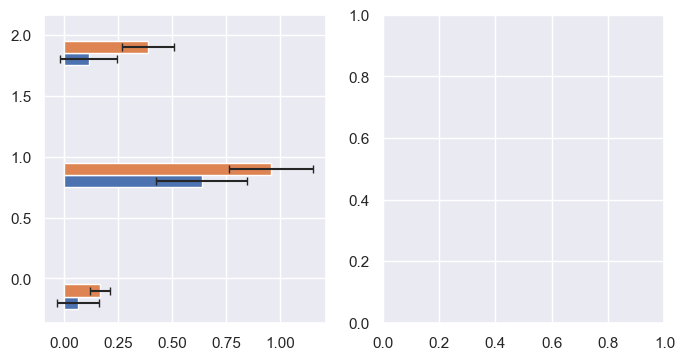

In [31]:
def plot_sobol(results):
    """ Bar plot of Sobol sensitivity indices. """
    
    sns.set()
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    si_list = results.sensitivity.sobol.groupby(by='reporter')
    si_conf_list = results.sensitivity.sobol_conf.groupby(by='reporter')

    for (key, si), (_, err), ax in zip(si_list, si_conf_list, axs):
        print(si)
        si = si.droplevel('reporter')
        print(si)
        err = err.droplevel('reporter')
        si.plot.barh(xerr=err, title=key, ax=ax, capsize = 3)
        ax.set_xlim(0)
    
    axs[0].get_legend().remove()
    axs[1].set(ylabel=None, yticklabels=[]) 
    axs[1].tick_params(left=False)
    plt.tight_layout()
    
plot_sobol(results)

Alternatively, we can also display sensitivities by plotting 
average evaluation measures over our parameter variations. 

agents


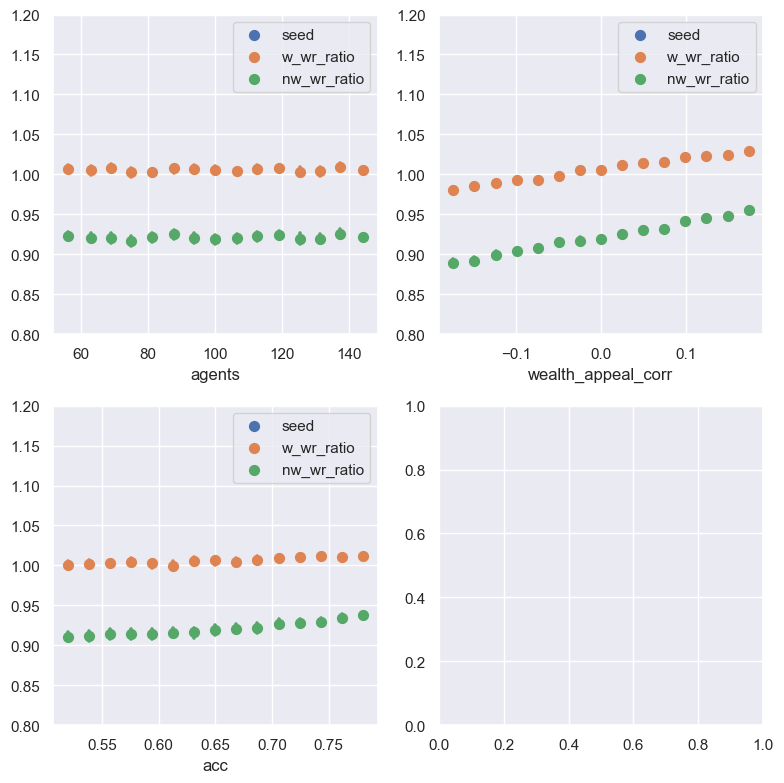

In [32]:
def plot_sensitivity(results):
    """ Show average simulation results for different parameter values. """
    
    sns.set()
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = [i for j in axs for i in j] # Flatten list
    
    data = results.arrange_reporters().astype('float')
    params = results.parameters.sample.keys() 
    print(params[0])
    
    for x, ax in zip(params, axs):
        for y in results.reporters.columns:
            sns.regplot(x=x, y=y, data=data, ax=ax, ci=99, 
                        x_bins=15, fit_reg=False, label=y)  
        ax.set_ylim(0.8,1.2)
        ax.set_ylabel('')
        ax.legend()
        
    plt.tight_layout()

plot_sensitivity(results)